In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def style_diag(data):
    '''author: CJR, https://stackoverflow.com/a/56916315'''
    diag_mask = pd.DataFrame("", index=data.index, columns=data.columns)
    min_axis = min(diag_mask.shape)
    diag_mask.iloc[range(min_axis), range(min_axis)] = 'background-color: yellow'
    return diag_mask

# Metric Analysis: Landcover Prediction (Africa)

## Single-Year Model Fold Average

### DataFrame (raw pixel count)

In [9]:
folds = ['12345', '23451', '34512', '45123', '51234']

df_raw_count_africa = pd.read_csv(f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_count_confusion_matrices/single_year_model/confusion_matrix_esri_urban_rural_{folds[0]}.csv', index_col=0)
for i in range(1, 5):
    dfi = pd.read_csv(f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_count_confusion_matrices/single_year_model/confusion_matrix_esri_urban_rural_{folds[i]}.csv', index_col=0)
    df_raw_count_africa = df_raw_count_africa.add(dfi, fill_value=0)

df_raw_count_africa = df_raw_count_africa.astype('int64')
df_raw_count_africa.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,3550159259,3862636,80985725,3802510,5261505,4389892,2287569,1560881
c2:Tree,101290603,73084285846,667511637,514371814,1659014,4841640873,295586013,83905098
c3:Flooded Vegetation,23870099,19946440,768263511,7437519,1125390,16305199,2896593,661070
c4:Crops,25190814,210006190,161440114,9810997594,37496415,1298092176,505042847,199332649
c5:Bare Ground,255415693,7912436,61416232,142352669,69381801638,4254219489,122147184,25480217
c6:Rangeland,208618556,14203621079,1633248410,8827164524,6810697046,113591842293,1669283948,288243217
c7:Rural,1548827,7878526,3137337,56283057,2425776,31507685,628507527,233813803
c8:Urban,1344092,5545500,2617387,34337695,556379,7287698,297812729,1280529162


In [10]:
df_raw_count_africa.sum(axis=1)

c1:Water                   3652309977
c2:Tree                   79590250898
c3:Flooded Vegetation       840505821
c4:Crops                  12247598799
c5:Bare Ground            74250745558
c6:Rangeland             147232719073
c7:Rural                    965102538
c8:Urban                   1630030642
dtype: int64

In [11]:
df_new = df_raw_count_africa.sum(axis=1)
df_new = df_new.div(df_new.sum(axis=0), axis=0)
df_new

c1:Water                 0.011399
c2:Tree                  0.248402
c3:Flooded Vegetation    0.002623
c4:Crops                 0.038225
c5:Bare Ground           0.231737
c6:Rangeland             0.459515
c7:Rural                 0.003012
c8:Urban                 0.005087
dtype: float64

# Accuracy

In [12]:
tp = df_raw_count_africa.to_numpy().diagonal().sum()
num_pixels = df_raw_count_africa.to_numpy().sum()
print(f'accuracy: {tp / num_pixels}')

accuracy: 0.8492151070243564


# Recall

### DataFrame (recall)

In [13]:
df_recall = df_raw_count_africa.div(df_raw_count_africa.sum(axis=1), axis=0)
df_recall.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,0.972,0.001,0.022,0.001,0.001,0.001,0.001,0.000
c2:Tree,0.001,0.918,0.008,0.006,0.000,0.061,0.004,0.001
c3:Flooded Vegetation,0.028,0.024,0.914,0.009,0.001,0.019,0.003,0.001
c4:Crops,0.002,0.017,0.013,0.801,0.003,0.106,0.041,0.016
c5:Bare Ground,0.003,0.000,0.001,0.002,0.934,0.057,0.002,0.000
c6:Rangeland,0.001,0.096,0.011,0.060,0.046,0.772,0.011,0.002
c7:Rural,0.002,0.008,0.003,0.058,0.003,0.033,0.651,0.242
c8:Urban,0.001,0.003,0.002,0.021,0.000,0.004,0.183,0.786


### Seaborn Heatmap (Recall)

Text(0.5, 23.52222222222222, 'Predicted label')

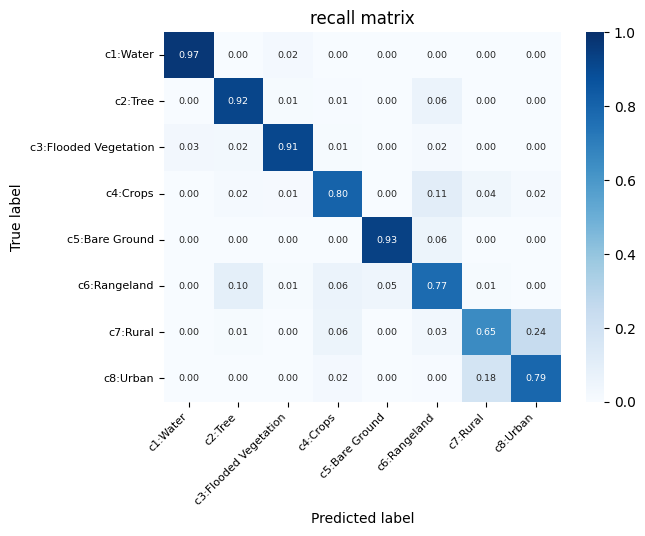

In [14]:
heatmap = sns.heatmap(data=df_recall, vmin=0.0, vmax=1.0, cmap=plt.cm.Blues, annot=True, annot_kws={"fontsize":6.8}, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.title('recall matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Recall score (per class accuracy)

In [15]:
class_names = df_recall.columns
confmat_diag = df_recall.to_numpy().diagonal()
per_class_acc = dict(zip(class_names, confmat_diag))
recall_scores = pd.DataFrame(per_class_acc.items(), columns=['class', 'recall'])
recall_scores = recall_scores.round(3)
print(recall_scores.to_string(index=False))

                class  recall
             c1:Water   0.972
              c2:Tree   0.918
c3:Flooded Vegetation   0.914
             c4:Crops   0.801
       c5:Bare Ground   0.934
         c6:Rangeland   0.772
             c7:Rural   0.651
             c8:Urban   0.786


In [16]:
confmat_diag

array([0.9720312 , 0.91825676, 0.91404901, 0.80105478, 0.93442566,
       0.77151222, 0.65123394, 0.78558594])

# Precision

### DataFrame (precision)

In [17]:
df_precision = df_raw_count_africa.div(df_raw_count_africa.sum(axis=0), axis=1)
df_precision.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,0.852,0.000,0.024,0.000,0.000,0.000,0.001,0.001
c2:Tree,0.024,0.835,0.198,0.027,0.000,0.039,0.084,0.040
c3:Flooded Vegetation,0.006,0.000,0.227,0.000,0.000,0.000,0.001,0.000
c4:Crops,0.006,0.002,0.048,0.506,0.000,0.010,0.143,0.094
c5:Bare Ground,0.061,0.000,0.018,0.007,0.910,0.034,0.035,0.012
c6:Rangeland,0.050,0.162,0.483,0.455,0.089,0.916,0.474,0.136
c7:Rural,0.000,0.000,0.001,0.003,0.000,0.000,0.178,0.111
c8:Urban,0.000,0.000,0.001,0.002,0.000,0.000,0.085,0.606


### Seaborn Heatmap (Precision)

Text(0.5, 23.52222222222222, 'Predicted label')

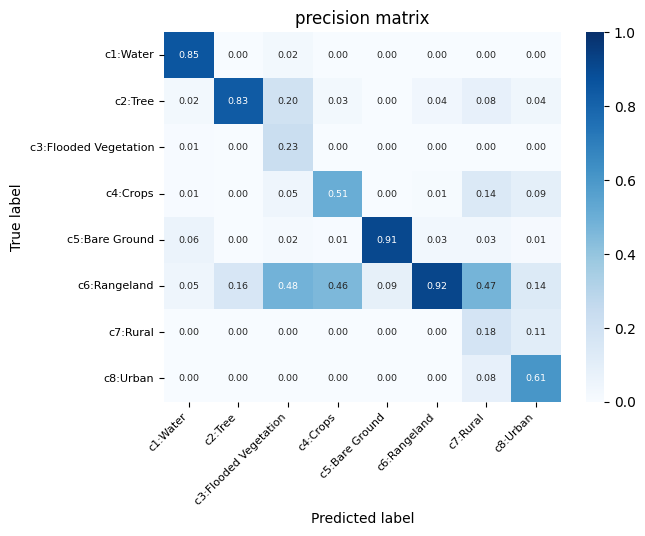

In [18]:
heatmap = sns.heatmap(data=df_precision, vmin=0.0, vmax=1.0, cmap=plt.cm.Blues, annot=True, annot_kws={"fontsize":6.8}, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.title('precision matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Precision score (prediction accuracy)

In [19]:
class_names = df_precision.columns
confmat_diag = df_precision.to_numpy().diagonal()
per_class_acc = dict(zip(class_names, confmat_diag))
precision_scores = pd.DataFrame(per_class_acc.items(), columns=['class', 'precision'])
precision_scores = precision_scores.round(3)
print(precision_scores.to_string(index=False))

                class  precision
             c1:Water      0.852
              c2:Tree      0.835
c3:Flooded Vegetation      0.227
             c4:Crops      0.506
       c5:Bare Ground      0.910
         c6:Rangeland      0.916
             c7:Rural      0.178
             c8:Urban      0.606


In [20]:
confmat_diag

array([0.85188053, 0.83483816, 0.22738971, 0.50580633, 0.9100324 ,
       0.91572882, 0.17837265, 0.60587336])

# IoU

In [21]:
class_names = df_raw_count_africa.columns
raw_counts = df_raw_count_africa.to_numpy()
iou_class = {}

# calculate IoU for each class
for i in range(len(class_names)):
    tp = raw_counts[i, i]
    fp = raw_counts[:, i].sum() - tp
    fn = raw_counts[i, :].sum() - tp
    
    nom = tp
    denom = (tp + fp + fn)
    
    if denom != 0:
        iou = nom / denom
    else:
        iou = np.NaN
    iou_class[class_names[i]] = iou


# output IoU as dataframe
iou_scores = pd.DataFrame(iou_class.items(), columns=['class', 'IoU'])
iou_scores.round(3)

,class,IoU
0,c1:Water,0.831
1,c2:Tree,0.777
2,c3:Flooded Vegetation,0.223
3,c4:Crops,0.449
4,c5:Bare Ground,0.855
5,c6:Rangeland,0.720
6,c7:Rural,0.163
7,c8:Urban,0.520


In [22]:
# calculate mean IoU (not counting empty classes)
iou_mean = np.nanmean(iou_scores['IoU'])
iou_mean

0.5673830330813707

# F1 Score (Dice coefficient)

In [23]:
class_names = df_raw_count_africa.columns
raw_counts = df_raw_count_africa.to_numpy()
f1_class = {}

# calculate IoU for each class
for i in range(len(class_names)):
    tp = raw_counts[i, i]
    fp = raw_counts[:, i].sum() - tp
    fn = raw_counts[i, :].sum() - tp
    
    nom = tp
    denom = tp + 0.5*(fp + fn)
    
    if denom != 0:
        f1 = nom / denom
    else:
        f1 = np.NaN
    f1_class[class_names[i]] = f1

# output f1-score as dataframe
f1_scores = pd.DataFrame(f1_class.items(), columns=['class', 'f1-score'])
f1_scores.round(3)

,class,f1-score
0,c1:Water,0.908
1,c2:Tree,0.875
2,c3:Flooded Vegetation,0.364
3,c4:Crops,0.620
4,c5:Bare Ground,0.922
5,c6:Rangeland,0.837
6,c7:Rural,0.280
7,c8:Urban,0.684


In [24]:
# calculate mean f1-score (not counting empty classes)
f1_mean = np.nanmean(f1_scores['f1-score'])
f1_mean

0.686314079600039

In [25]:
iou_f1 = iou_scores.set_index('class').join(f1_scores.set_index('class'))
iou_f1_mean = pd.DataFrame({'class': ['mean'], 'IoU': [iou_mean], 'f1-score': [f1_mean]}).set_index('class')
iou_f1 = pd.concat([iou_f1, iou_f1_mean])
iou_f1.round(3)

,IoU,f1-score
class,,
c1:Water,0.831,0.908
c2:Tree,0.777,0.875
c3:Flooded Vegetation,0.223,0.364
c4:Crops,0.449,0.620
c5:Bare Ground,0.855,0.922
c6:Rangeland,0.720,0.837
c7:Rural,0.163,0.280
c8:Urban,0.520,0.684
mean,0.567,0.686
